In [136]:
import datetime

import tensorflow_datasets as tfds
import tensorflow as tf

(ds_train, ds_test), ds_info = tfds.load('mnist',
                                         split=['train', 'test'],
                                         as_supervised=True,
                                         with_info=True)


%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [137]:
sz_train = ds_info.splits['train'].num_examples
sz_test = ds_info.splits['test'].num_examples
img_shape = ds_info.features['image'].shape
img_type = ds_info.features['image'].dtype

sz_train, sz_test, img_shape, img_type

(60000, 10000, (28, 28, 1), tf.uint8)

- there are 60k training, 10k test samples, each image is 28x28 pixels, and each pixel has 1 byte = 0xFF = 255 possible values

2022-11-21 19:46:02.565376: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


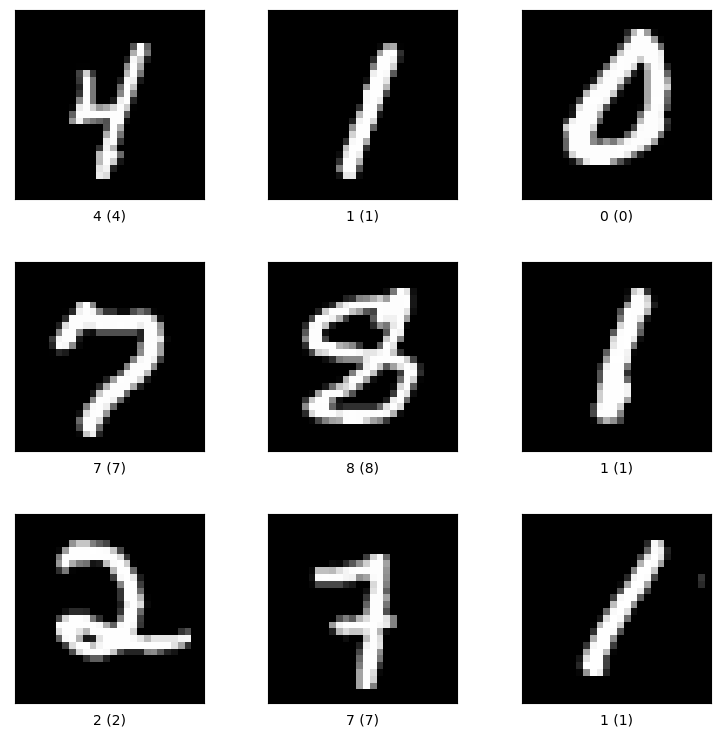

In [138]:
examples = tfds.show_examples(ds_train, ds_info)

### 2.2 Setting up the data pipeline

In [139]:
def pipeline(dataset):
    return dataset.map(lambda img, label: (tf.reshape(tf.cast(img, tf.float32) / 128.0 - 1, [-1]),
                                           tf.one_hot(label, 10, dtype=tf.float32)),
                       num_parallel_calls=tf.data.AUTOTUNE)\
                  .batch(32)\
                  .prefetch(tf.data.AUTOTUNE)\
                  #.cache()


ds_train_t = pipeline(ds_train)
ds_test_t = pipeline(ds_test)

### 2.3 Building deep neural network with TF

In [140]:
class MNIST(tf.keras.Model):
  def __init__(self, layers_list, metrics_list, optimizer, loss_fn):
    super(MNIST, self).__init__()
    self.layers_list = layers_list
    self.metrics_list = metrics_list
    self.optimizer = optimizer
    self.loss_fn = loss_fn
    
  def reset_metrics(self):
    for metric in self.metrics:
      metric.reset_states()
   
  def call(self, x, training=False):
    for layer in self.layers_list:
      x = layer(x)
    return x
   
  @tf.function
  def train_step(self, data):
    x, target = data
    
    with tf.GradientTape() as tape:
      prediction = self(x, training=True)
      loss = self.loss_fn(target, prediction)
    
    gradients = tape.gradient(loss, self.trainable_variables)
    self.optimizer.apply_gradients(zip(gradients, self.trainable_variables))
    
    self.metrics[0].update_state(loss)
    for metric in self.metrics[1:]:
      metric.update_state(target, prediction)
      
    return {m.name: m.result() for m in self.metrics}
     
  @tf.function
  def test_step(self, data):
    x, target = data
    prediction = self(x, training=False)
    loss = self.loss_fn(target, prediction) + tf.reduce_sum(self.losses)
    
    self.metrics[0].update_state(loss)
    for metric in self.metrics[1:]:
      metric.update_state(target, prediction)
    return {m.name: m.result() for m in self.metrics}

### 2.4 Training the network

In [159]:
# set seed for reproducible/deterministic computations
tf.keras.utils.set_random_seed(133742069)

layers_list = [tf.keras.layers.Dense(784, activation='relu'),
               tf.keras.layers.Dense(256, activation='relu'),
               tf.keras.layers.Dense(256, activation='relu'),
               tf.keras.layers.Dense(10)]

metrics_list = [tf.keras.metrics.Mean(name='loss'),
                tf.keras.metrics.CategoricalAccuracy(name='accuracy'),
                tf.keras.metrics.MeanSquaredError(name='mse')]

optimizer = tf.keras.optimizers.SGD(learning_rate=0.1)
loss_fn   = tf.keras.losses.CategoricalCrossentropy(from_logits=True)

model = MNIST(layers_list, metrics_list, optimizer, loss_fn)
model(tf.keras.Input((784,)))
model.summary()

Model: "mnist_34"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_144 (Dense)           multiple                  615440    
                                                                 
 dense_145 (Dense)           multiple                  200960    
                                                                 
 dense_146 (Dense)           multiple                  65792     
                                                                 
 dense_147 (Dense)           multiple                  2570      
                                                                 
Total params: 884,768
Trainable params: 884,762
Non-trainable params: 6
_________________________________________________________________


In [160]:
import tqdm
import pprint

def training_loop(model, train_ds, val_ds, epochs):
  train_metrics = {m.name: [] for m in model.metrics}
  val_metrics = {m.name: [] for m in model.metrics}
  
  for epoch in range(epochs):
    print(f'Epoch {epoch}')
    
    # Training
    
    for data in tqdm.tqdm(train_ds, position=0, leave=True):
      metrics = model.train_step(data)
      
    print([f'{key}: {value.numpy()}' for key, value in metrics.items()])
    for key, value in metrics.items():
      train_metrics[key].append(value.numpy())
    model.reset_metrics()
    
    # Validation
    
    for data in val_ds:
      metrics = model.test_step(data)
      
    print([f'val_{key}: {value.numpy()}' for key, value in metrics.items()])
    for key, value in metrics.items():
      val_metrics[key].append(value.numpy())
    model.reset_metrics()
    
    print()
  return train_metrics, val_metrics

In [161]:
epochs = 10

train_metrics, val_metrics = training_loop(model, ds_train_t, ds_test_t, epochs)

Epoch 0


100%|██████████| 1875/1875 [00:26<00:00, 71.57it/s] 


['loss: 0.3305595815181732', 'accuracy: 0.8940333127975464', 'mse: 10.84502124786377']
['val_loss: 0.14721475541591644', 'val_accuracy: 0.9539999961853027', 'val_mse: 14.045801162719727']

Epoch 1


100%|██████████| 1875/1875 [00:26<00:00, 70.49it/s]


['loss: 0.12484905123710632', 'accuracy: 0.9613500237464905', 'mse: 18.43893814086914']
['val_loss: 0.1332063376903534', 'val_accuracy: 0.9571999907493591', 'val_mse: 19.85637092590332']

Epoch 2


100%|██████████| 1875/1875 [00:27<00:00, 68.50it/s]


['loss: 0.08640887588262558', 'accuracy: 0.9733499884605408', 'mse: 24.549583435058594']
['val_loss: 0.0888071358203888', 'val_accuracy: 0.9726999998092651', 'val_mse: 27.2496280670166']

Epoch 3


100%|██████████| 1875/1875 [00:30<00:00, 61.15it/s]


['loss: 0.06352750211954117', 'accuracy: 0.9797666668891907', 'mse: 31.121129989624023']
['val_loss: 0.08948526531457901', 'val_accuracy: 0.9731000065803528', 'val_mse: 32.48063659667969']

Epoch 4


100%|██████████| 1875/1875 [00:32<00:00, 57.69it/s]


['loss: 0.053114134818315506', 'accuracy: 0.98294997215271', 'mse: 36.13847732543945']
['val_loss: 0.08865614235401154', 'val_accuracy: 0.9725000262260437', 'val_mse: 39.97007369995117']

Epoch 5


100%|██████████| 1875/1875 [00:29<00:00, 64.54it/s]


['loss: 0.04113871604204178', 'accuracy: 0.9866499900817871', 'mse: 43.40543746948242']
['val_loss: 0.08535868674516678', 'val_accuracy: 0.9757000207901001', 'val_mse: 47.98802185058594']

Epoch 6


100%|██████████| 1875/1875 [00:41<00:00, 45.65it/s]


['loss: 0.03669340908527374', 'accuracy: 0.9879166483879089', 'mse: 50.00462341308594']
['val_loss: 0.08163280040025711', 'val_accuracy: 0.9763000011444092', 'val_mse: 50.57173538208008']

Epoch 7


100%|██████████| 1875/1875 [00:28<00:00, 64.99it/s]


['loss: 0.029924197122454643', 'accuracy: 0.989633321762085', 'mse: 56.6245231628418']
['val_loss: 0.08965082466602325', 'val_accuracy: 0.9772999882698059', 'val_mse: 66.21459197998047']

Epoch 8


100%|██████████| 1875/1875 [00:29<00:00, 63.29it/s]


['loss: 0.031519755721092224', 'accuracy: 0.9896666407585144', 'mse: 64.5475082397461']
['val_loss: 0.08883289247751236', 'val_accuracy: 0.9750000238418579', 'val_mse: 64.84587860107422']

Epoch 9


100%|██████████| 1875/1875 [00:29<00:00, 62.65it/s]


['loss: 0.02582145854830742', 'accuracy: 0.9915333390235901', 'mse: 66.6207275390625']
['val_loss: 0.08844226598739624', 'val_accuracy: 0.978600025177002', 'val_mse: 75.95411682128906']



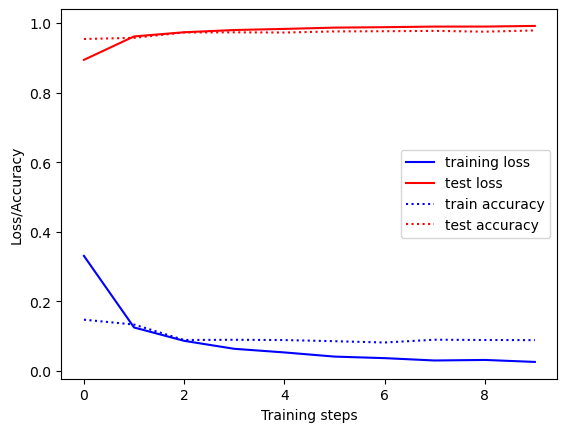

In [163]:
import matplotlib.pyplot as plt
import numpy as np

def visualization(train_losses, train_accuracies, test_losses, test_accuracies ):
  plt.figure()
  line1, = plt.plot(train_losses , "b-")
  line2, = plt.plot(test_losses , "r-")
  line3, = plt.plot(train_accuracies , "b:")
  line4, = plt.plot(test_accuracies , "r:")

  plt.xlabel("Training steps")
  plt.ylabel("Loss/Accuracy")
  plt.legend((line1 , line2 , line3 , line4), 
             ("training loss", "test loss", "train accuracy", "test accuracy"))
  plt.show()
  
visualization(train_metrics['loss'], 
              val_metrics['loss'], 
              train_metrics['accuracy'], 
              val_metrics['accuracy'])

# 3 Adjusting the hyperparameters

Model: "mnist_39"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_166 (Dense)           multiple                  615440    
                                                                 
 dense_167 (Dense)           multiple                  200960    
                                                                 
 dense_168 (Dense)           multiple                  2570      
                                                                 
Total params: 818,974
Trainable params: 818,970
Non-trainable params: 4
_________________________________________________________________
Epoch 0


100%|██████████| 1875/1875 [00:24<00:00, 76.57it/s]


['loss: 0.3050033450126648', 'accuracy: 0.9039333462715149']
['val_loss: 0.15119042992591858', 'val_accuracy: 0.9496999979019165']

Epoch 1


100%|██████████| 1875/1875 [00:27<00:00, 69.04it/s]


['loss: 0.11557621508836746', 'accuracy: 0.9640499949455261']
['val_loss: 0.09537819027900696', 'val_accuracy: 0.9706000089645386']

Epoch 2


100%|██████████| 1875/1875 [00:30<00:00, 61.37it/s]


['loss: 0.07823739945888519', 'accuracy: 0.9761166572570801']
['val_loss: 0.08379082381725311', 'val_accuracy: 0.9746999740600586']

Epoch 3


100%|██████████| 1875/1875 [00:28<00:00, 65.79it/s]


['loss: 0.05752904340624809', 'accuracy: 0.9821500182151794']
['val_loss: 0.07922448962926865', 'val_accuracy: 0.9753000140190125']

Epoch 4


100%|██████████| 1875/1875 [00:28<00:00, 66.09it/s]


['loss: 0.043886698782444', 'accuracy: 0.9862666726112366']
['val_loss: 0.07873456180095673', 'val_accuracy: 0.9779999852180481']

Epoch 5


100%|██████████| 1875/1875 [00:28<00:00, 65.06it/s]


['loss: 0.03534773737192154', 'accuracy: 0.9887166619300842']
['val_loss: 0.08416744321584702', 'val_accuracy: 0.9739000201225281']

Epoch 6


100%|██████████| 1875/1875 [00:29<00:00, 64.43it/s]


['loss: 0.02734677493572235', 'accuracy: 0.9910666942596436']
['val_loss: 0.07794669270515442', 'val_accuracy: 0.9778000116348267']

Epoch 7


100%|██████████| 1875/1875 [00:28<00:00, 65.37it/s]


['loss: 0.02301877923309803', 'accuracy: 0.9926166534423828']
['val_loss: 0.0821480005979538', 'val_accuracy: 0.9776999950408936']

Epoch 8


100%|██████████| 1875/1875 [00:27<00:00, 67.84it/s]


['loss: 0.021059434860944748', 'accuracy: 0.9931166768074036']
['val_loss: 0.09563353657722473', 'val_accuracy: 0.9745000004768372']

Epoch 9


100%|██████████| 1875/1875 [00:31<00:00, 60.25it/s]


['loss: 0.017020560801029205', 'accuracy: 0.9944000244140625']
['val_loss: 0.07548291236162186', 'val_accuracy: 0.9793999791145325']



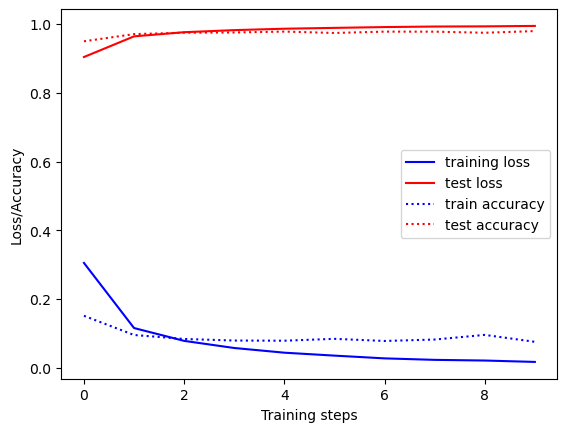

In [169]:
tf.keras.utils.set_random_seed(133742069)

layers_list_new = [tf.keras.layers.Dense(784, activation='relu'),
                   tf.keras.layers.Dense(256, activation='relu'),
                   tf.keras.layers.Dense(10)]

metrics_list_new = [tf.keras.metrics.Mean(name='loss'),
                    tf.keras.metrics.CategoricalAccuracy(name='accuracy')]

optimizer_new = tf.keras.optimizers.SGD(learning_rate=0.1)
loss_fn_new   = tf.keras.losses.CategoricalCrossentropy(from_logits=True)

model_new = MNIST(layers_list_new, metrics_list_new, optimizer_new, loss_fn_new)
model_new(tf.keras.Input((784,)))
model_new.summary()

train_metrics_new, val_metrics_new = training_loop(model_new, ds_train_t, ds_test_t, epochs)

visualization(train_metrics_new['loss'], 
              val_metrics_new['loss'], 
              train_metrics_new['accuracy'], 
              val_metrics_new['accuracy'])

- by removing a layer and decreasing the remaining layer's number of neural units, it was possible to maintain (slightly increase) the accuracy

Model: "mnist_43"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_180 (Dense)           multiple                  615440    
                                                                 
 dense_181 (Dense)           multiple                  200960    
                                                                 
 dense_182 (Dense)           multiple                  2570      
                                                                 
Total params: 818,974
Trainable params: 818,970
Non-trainable params: 4
_________________________________________________________________
Epoch 0


100%|██████████| 1875/1875 [00:21<00:00, 85.92it/s]


['loss: 0.28458502888679504', 'accuracy: 0.911216676235199']
['val_loss: 0.14055655896663666', 'val_accuracy: 0.9562000036239624']

Epoch 1


100%|██████████| 1875/1875 [00:26<00:00, 70.63it/s]


['loss: 0.11773578077554703', 'accuracy: 0.9646833539009094']
['val_loss: 0.09469204396009445', 'val_accuracy: 0.9697999954223633']

Epoch 2


100%|██████████| 1875/1875 [00:27<00:00, 68.83it/s]


['loss: 0.0810026153922081', 'accuracy: 0.9757500290870667']
['val_loss: 0.07847408205270767', 'val_accuracy: 0.9739000201225281']

Epoch 3


100%|██████████| 1875/1875 [00:24<00:00, 77.31it/s]


['loss: 0.05959463119506836', 'accuracy: 0.9820333123207092']
['val_loss: 0.07074384391307831', 'val_accuracy: 0.977400004863739']

Epoch 4


100%|██████████| 1875/1875 [00:26<00:00, 71.38it/s]


['loss: 0.0447608046233654', 'accuracy: 0.9871500134468079']
['val_loss: 0.0685701072216034', 'val_accuracy: 0.9789999723434448']

Epoch 5


100%|██████████| 1875/1875 [00:31<00:00, 59.40it/s]


['loss: 0.03369970619678497', 'accuracy: 0.9910833239555359']
['val_loss: 0.06629490107297897', 'val_accuracy: 0.979200005531311']

Epoch 6


100%|██████████| 1875/1875 [00:32<00:00, 58.02it/s]


['loss: 0.025715867057442665', 'accuracy: 0.9932666420936584']
['val_loss: 0.06499172002077103', 'val_accuracy: 0.9803000092506409']

Epoch 7


100%|██████████| 1875/1875 [00:39<00:00, 47.73it/s]


['loss: 0.01953621208667755', 'accuracy: 0.9954000115394592']
['val_loss: 0.06592138856649399', 'val_accuracy: 0.9803000092506409']

Epoch 8


100%|██████████| 1875/1875 [00:32<00:00, 57.19it/s]


['loss: 0.01430668868124485', 'accuracy: 0.9970666766166687']
['val_loss: 0.06442376226186752', 'val_accuracy: 0.98089998960495']

Epoch 9


100%|██████████| 1875/1875 [00:38<00:00, 48.78it/s]


['loss: 0.011202950961887836', 'accuracy: 0.99795001745224']
['val_loss: 0.0662984848022461', 'val_accuracy: 0.9810000061988831']



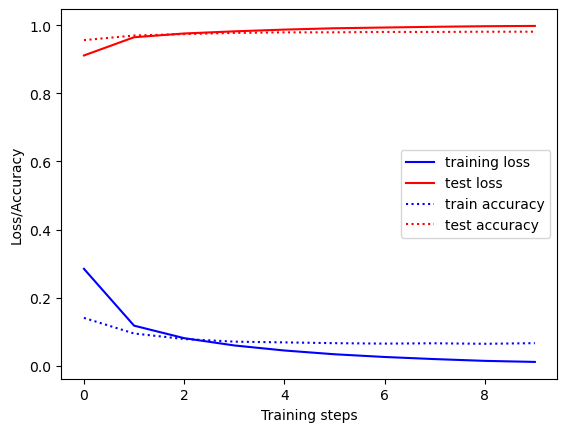

In [174]:
tf.keras.utils.set_random_seed(133742069)

layers_list_new = [tf.keras.layers.Dense(784, activation='relu'),
                   tf.keras.layers.Dense(256, activation='relu'),
                   tf.keras.layers.Dense(10)]

metrics_list_new = [tf.keras.metrics.Mean(name='loss'),
                    tf.keras.metrics.CategoricalAccuracy(name='accuracy')]

optimizer_new = tf.keras.optimizers.SGD(learning_rate=0.05)
loss_fn_new   = tf.keras.losses.CategoricalCrossentropy(from_logits=True)

model_new = MNIST(layers_list_new, metrics_list_new, optimizer_new, loss_fn_new)
model_new(tf.keras.Input((784,)))
model_new.summary()

train_metrics_new, val_metrics_new = training_loop(model_new, ds_train_t, ds_test_t, epochs)

visualization(train_metrics_new['loss'], 
              val_metrics_new['loss'], 
              train_metrics_new['accuracy'], 
              val_metrics_new['accuracy'])

- decreasing the learning rate to 0.05 slightly increased performance

Model: "mnist_50"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_203 (Dense)           multiple                  615440    
                                                                 
 dense_204 (Dense)           multiple                  200960    
                                                                 
 dense_205 (Dense)           multiple                  2570      
                                                                 
Total params: 818,974
Trainable params: 818,970
Non-trainable params: 4
_________________________________________________________________
Epoch 0


100%|██████████| 1875/1875 [00:25<00:00, 74.80it/s]


['loss: 0.2869180738925934', 'accuracy: 0.9099833369255066']
['val_loss: 0.16238336265087128', 'val_accuracy: 0.9456999897956848']

Epoch 1


100%|██████████| 1875/1875 [00:33<00:00, 55.84it/s]


['loss: 0.11516700685024261', 'accuracy: 0.9646499752998352']
['val_loss: 0.09377805888652802', 'val_accuracy: 0.9699000120162964']

Epoch 2


100%|██████████| 1875/1875 [00:49<00:00, 38.05it/s]


['loss: 0.07854098826646805', 'accuracy: 0.9758999943733215']
['val_loss: 0.07934113591909409', 'val_accuracy: 0.9740999937057495']

Epoch 3


100%|██████████| 1875/1875 [00:35<00:00, 53.46it/s]


['loss: 0.05682062357664108', 'accuracy: 0.9827333092689514']
['val_loss: 0.07518881559371948', 'val_accuracy: 0.9764000177383423']

Epoch 4


100%|██████████| 1875/1875 [00:41<00:00, 45.62it/s]


['loss: 0.04198146238923073', 'accuracy: 0.9878666400909424']
['val_loss: 0.06599350273609161', 'val_accuracy: 0.9794999957084656']

Epoch 5


100%|██████████| 1875/1875 [00:36<00:00, 51.56it/s]


['loss: 0.03149552643299103', 'accuracy: 0.9910833239555359']
['val_loss: 0.06491726636886597', 'val_accuracy: 0.9789000153541565']

Epoch 6


100%|██████████| 1875/1875 [00:32<00:00, 58.11it/s]


['loss: 0.023611854761838913', 'accuracy: 0.9934999942779541']
['val_loss: 0.06646980345249176', 'val_accuracy: 0.9789999723434448']

Epoch 7


100%|██████████| 1875/1875 [00:30<00:00, 61.97it/s]


['loss: 0.01800161600112915', 'accuracy: 0.9948999881744385']
['val_loss: 0.06493112444877625', 'val_accuracy: 0.9805999994277954']

Epoch 8


100%|██████████| 1875/1875 [00:30<00:00, 62.43it/s]


['loss: 0.01588888093829155', 'accuracy: 0.9957833290100098']
['val_loss: 0.07097965478897095', 'val_accuracy: 0.9786999821662903']

Epoch 9


100%|██████████| 1875/1875 [00:29<00:00, 63.43it/s]


['loss: 0.012919923290610313', 'accuracy: 0.996566653251648']
['val_loss: 0.0645638108253479', 'val_accuracy: 0.982200026512146']



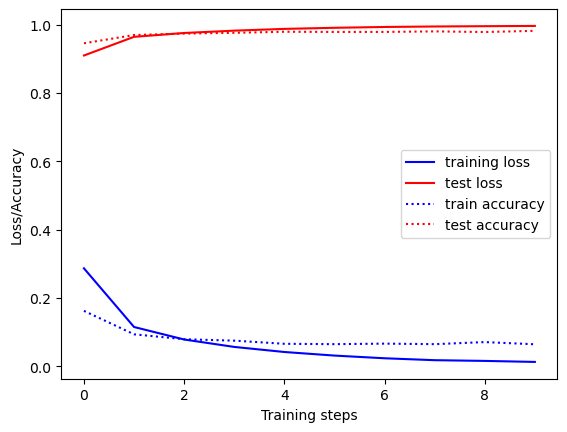

In [181]:

tf.keras.utils.set_random_seed(133742069)

layers_list_new = [tf.keras.layers.Dense(784, activation='relu'),
                   tf.keras.layers.Dense(256, activation='relu'),
                   tf.keras.layers.Dense(10)]

metrics_list_new = [tf.keras.metrics.Mean(name='loss'),
                    tf.keras.metrics.CategoricalAccuracy(name='accuracy')]

optimizer_new = tf.keras.optimizers.SGD(learning_rate=0.07)
loss_fn_new   = tf.keras.losses.CategoricalCrossentropy(from_logits=True)

model_new = MNIST(layers_list_new, metrics_list_new, optimizer_new, loss_fn_new)
model_new(tf.keras.Input((784,)))
model_new.summary()

train_metrics_new, val_metrics_new = training_loop(model_new, ds_train_t, ds_test_t, epochs)

visualization(train_metrics_new['loss'], 
              val_metrics_new['loss'], 
              train_metrics_new['accuracy'], 
              val_metrics_new['accuracy'])

- increasing the learning rate to 0.07 seemed to increase performance a tiny bit further